# A Simple Autoencoder using Hi-C data

## 0. Functions

## 0.1 Hi-C class

In [1]:
# Third-party modules
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix


class Hic:
    """
    .. class:: Hic
 
        This class groups informations about a Hi-C matrix.

    Attributes:
        sparse (Pandas DataFrame): A data frame containing the Hi-C sparse matrix.
        resolution (int): The resolution of the matrix.
        start (int):
        end (int):
        size (int):
        matrix (numpy array):
    """

    def __init__(self, filename, resolution):
        self.df = pd.read_csv(filename, sep='\t', header=None)
        self.df.columns = ['chr', 'base_1', 'base_2', 'value']
        self.resolution = resolution
        self.start = int(self.df['base_1'].iloc[0])
        self.end = int(self.df['base_2'].iloc[-1])
        self.size = int(self.end / self.resolution)
        self.matrix = None
        self.sub_matrices = None

    def set_matrix(self):
        """
            Create a sparse matrix in a very fast way using scipy.sparse module
            and convert it into a numpy array.
        """
        # All the values are stored in a numpy array
        # The matrix will be symetric, so the values must be added twice
        values = self.df.value
        data = np.array(values.append(values))
        # base_1 and base_2 columns must be converted to index by dividing by the resolution number
        # This step is necesary for the creation of the sparse matrix with scipy.sparse
        base_1_index = ((self.df.base_1 / resolution)+1).astype(int)
        base_2_index = ((self.df.base_2 / resolution)+1).astype(int)
        row = np.array(base_1_index.append(base_2_index))
        col = np.array(base_2_index.append(base_1_index))
        # Creation of the sparse matrix and conversion into a numpy array
        self.matrix = coo_matrix((data, (row, col)), shape=(self.size+2, self.size+2)).toarray()
        # Conversion in float32 format
        self.matrix = self.matrix.astype(np.float32)
        # Logarithmic rescale
        self.matrix = np.log(self.matrix+1)
        # Rescaling of the values in range 0-1 (min-max scaling method)
        self.matrix = (self.matrix - self.matrix.min()) / (self.matrix.max() - self.matrix.min())
        # other method :
        # self.matrix = self.matrix / self.matrix.max()
        
    def set_sub_matrices(self, nrow, ncol, nele=1):
        """
            Reshape of the sparse matrix in order to obtain N matrices of size nrow*ncol.
            
            Args:
                nrow (int): Number of rows for a sub-matrix
                ncol (int): Number of columns a sub-matrix
                nele (int): Number of element in a list (Default=1)
        """
        self.sub_matrices = self.matrix.reshape(-1, nrow, ncol, nele)
        ## Another less fancy method
        # l = []
        # for i in range(0, h.matrix.shape[1], nrow):
        #     for j in range(0, h.matrix.shape[1], ncol):
        #         l.append(h.matrix[i:i+nrow, j:j+ncol])
        # self.matrix = np.array(l)


    def get_value(self, chr_num, base_1, base_2):
        """
            Search in a Pandas Dataframe (the Hi-C/NGS matrix) the unique row described
            by two given nucleotide bases and return the value corresponding.

            Args:
                chr_num (str): Name pf the chromosome.
                base_1 (int): Index of the first nucleotide base.
                base_2 (int): Index of the second nucleotide base.
            Returns:
                float: The corresponding value if the row exists or 0 if not.
        """
        # The row could be find by two combinations (base_1 base_2 or base_2 base_1)
        if not isinstance(base_1, int) or not isinstance(base_2, int):
            raise TypeError("Args must be integer.")

        filtered_matrix_1 = self.df[(self.df['chr'] == chr_num) &
                                    (self.df['base_1'] == base_1) &
                                    (self.df['base_2'] == base_2)]
        filtered_matrix_2 = self.df[(self.df['chr'] == chr_num) &
                                    (self.df['base_1'] == base_2) &
                                    (self.df['base_2'] == base_1)]

        # The row do exist in one of the two filtered data frames :
        if not filtered_matrix_1.empty:
            return float(filtered_matrix_1['value'])
        elif not filtered_matrix_2.empty:
            return float(filtered_matrix_2['value'])
        # The row does not exist :
        return 0

## 0.2 Displays

In [17]:
def display_shape(name, matrix):
    print("{}: {} sub-matrices of size {}*{}*{}"
          .format(name, matrix.shape[0], matrix.shape[1], matrix.shape[2], matrix.shape[3]))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random as rd
%matplotlib inline

In [4]:
def plot_sub_matrices(dataset, cmp):
    plt.figure(figsize=(22, 2))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        # img_random = rd.randint(0, h.sub_matrices.shape[0])
        plt.imshow(dataset[i, ..., 0], cmap=cmp)
        plt.title("submatrix n°{}".format(i))

The 'Reds' color map from matplotlib does not contain the white color (Very used for Hi-C matrix when the value=0).

In [3]:
reds = cm.get_cmap('Reds', 300)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((white, reds(np.linspace(0, 1, 300))))
newcmp = ListedColormap(newcolors)

## 1. Loading the data and Conversions

### Implementation of the Hic class regrouping all informations about a Hi-C matrix.

## 1.1 Hic object

The Hic input file is stored in a Pandas DataFrame.

Our example takes in input the chromosome 20 of the **GSE63525 HUVEC** genome (`GSE63525_HUVEC_combined_30.hic.gz` file).

In [5]:
filename = 'data/chr20.txt'
resolution = 25000
h = Hic(filename, resolution)

In [6]:
h.df.head()

,chr,base_1,base_2,value
0,chr20,50000,50000,1011.12650
1,chr20,50000,75000,269.99036
2,chr20,75000,75000,823.17410
3,chr20,50000,100000,189.63887
4,chr20,75000,100000,261.08728


## 1.2 Sparse matrix

Conversion of the Pandas DataFrame into a numpy array. The values are rescaled by log and then by min-max scaling (values between 0 and 1).

In [7]:
h.set_matrix()

In [8]:
print("Sparse matrix of size {}*{}.".format(h.matrix.shape[0], h.matrix.shape[1]))
print("Min={}, Max={}, Mean={}".format(h.matrix.min(), h.matrix.max(), h.matrix.mean()))
pd.DataFrame(h.matrix).head(10)

Sparse matrix of size 2520*2520.
Min=0.0, Max=1.0, Mean=0.04458340257406235


,0,1,2,3,4,5,6,7,8,9,...,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.913263,0.672079,0.629886,0.583433,0.604819,0.525902,0.571164,...,0.0,0.0,0.000000,0.000000,0.000000,0.140635,0.000000,0.175130,0.0,0.0
4,0.0,0.0,0.0,0.672079,0.888605,0.668071,0.646524,0.605912,0.556505,0.567299,...,0.0,0.0,0.095667,0.173490,0.000000,0.106139,0.096190,0.136069,0.0,0.0
5,0.0,0.0,0.0,0.629886,0.668071,0.887956,0.670729,0.619465,0.569752,0.541826,...,0.0,0.0,0.119096,0.000000,0.119295,0.192143,0.000000,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.583433,0.646524,0.670729,0.878122,0.659150,0.605885,0.586548,...,0.0,0.0,0.000000,0.116754,0.000000,0.000000,0.150089,0.000000,0.0,0.0
7,0.0,0.0,0.0,0.604819,0.605912,0.619465,0.659150,0.869276,0.669785,0.626813,...,0.0,0.0,0.161830,0.127672,0.000000,0.117524,0.200389,0.213597,0.0,0.0
8,0.0,0.0,0.0,0.525902,0.556505,0.569752,0.605885,0.669785,0.875572,0.664989,...,0.0,0.0,0.092068,0.111642,0.143762,0.193978,0.180182,0.192856,0.0,0.0
9,0.0,0.0,0.0,0.571164,0.567299,0.541826,0.586548,0.626813,0.664989,0.869167,...,0.0,0.0,0.000000,0.102865,0.000000,0.000000,0.168796,0.220592,0.0,0.0


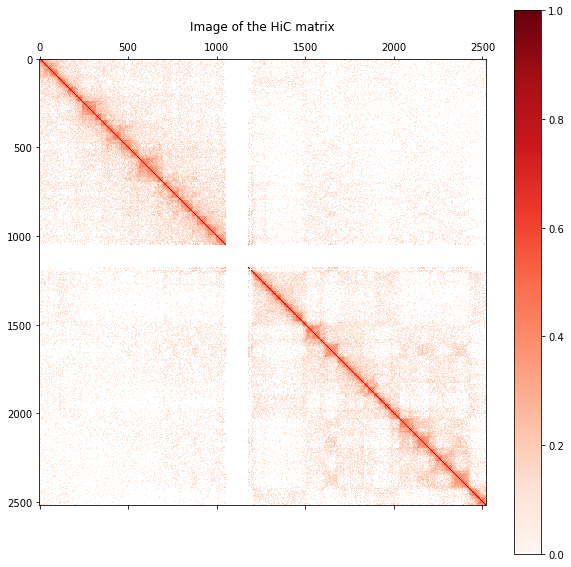

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_title('Image of the HiC matrix')
im = ax.matshow(h.matrix, cmap=newcmp)
fig.colorbar(im)

## 1.3 Sub-matrices

We want to reshape the matrix into N sub-matrices of size n*n*1 in order to create a  training and a test datasets to train and then test the Autoencoder.

In [10]:
n = 60
h.set_sub_matrices(n, n)

In [18]:
display_shape("Hi-C matrix", h.sub_matrices)

Hi-C matrix: 1764 sub-matrices of size 60*60*1


10 random sub-matrices :


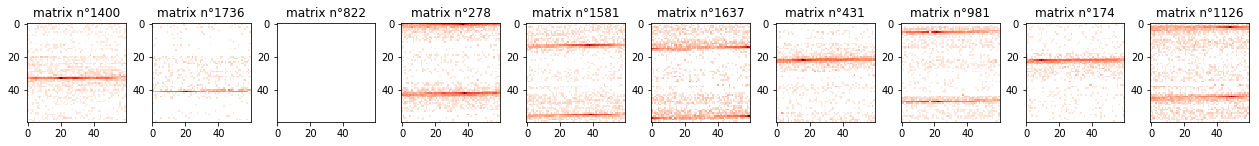

In [14]:
plot_sub_matrices(h.sub_matrices, cmp)

## 1.4 Data sets

### Train and test sets

In [19]:
random_index = rd.sample(range(0, h.sub_matrices.shape[0]), h.sub_matrices.shape[0])
sep = 1500

train = h.sub_matrices[random_index[:sep]]
test = h.sub_matrices[random_index[sep:]]

In [20]:
display_shape("Training set", train)
display_shape("Test set", test)

Training set: 1500 sub-matrices of size 60*60*1
Test set: 264 sub-matrices of size 60*60*1


### Split the training set into train_X (= 80% of the data) and valid_X (= 20% of the data) sets

In [21]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train,
                                                             train, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [22]:
display_shape("Train set", train_X)
display_shape("Validation set", valid_X)

Train set: 1200 sub-matrices of size 60*60*1
Validation set: 300 sub-matrices of size 60*60*1


## 2. Implementation of the Autoencoder

In [23]:
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import h5py

Using TensorFlow backend.


## 2.1 Parameters and building of the Model

In [24]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = n, n
input_img = Input(shape = (x, y, inChannel))

In [25]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #60 x 60 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 60 x 60 x 1
    return decoded

In [26]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## 2.2 Train the model

In [28]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Instructions for updating:
Use tf.cast instead.
Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0321 - val_loss: 0.0085
Epoch 2/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 3/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 4/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 5/50
1200/1200 [==============================] - 24s 20ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 6/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 7/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 8/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 9/50
1200/1200 [==============================] - 24s 20ms/step - l

## 2.3 Training and Validation Loss Plot

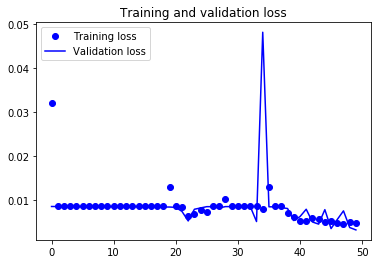

In [29]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
pred = autoencoder.predict(test)

In [31]:
print("Test set = {} sub-matrices {}*{}*{}"
      .format(test.shape[0], test.shape[1], test.shape[2], test.shape[3]))
print("Pred set = {} sub-matrices {}*{}*{}"
      .format(pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3]))

Test set = 264 sub-matrices 60*60*1
Pred set = 264 sub-matrices 60*60*1


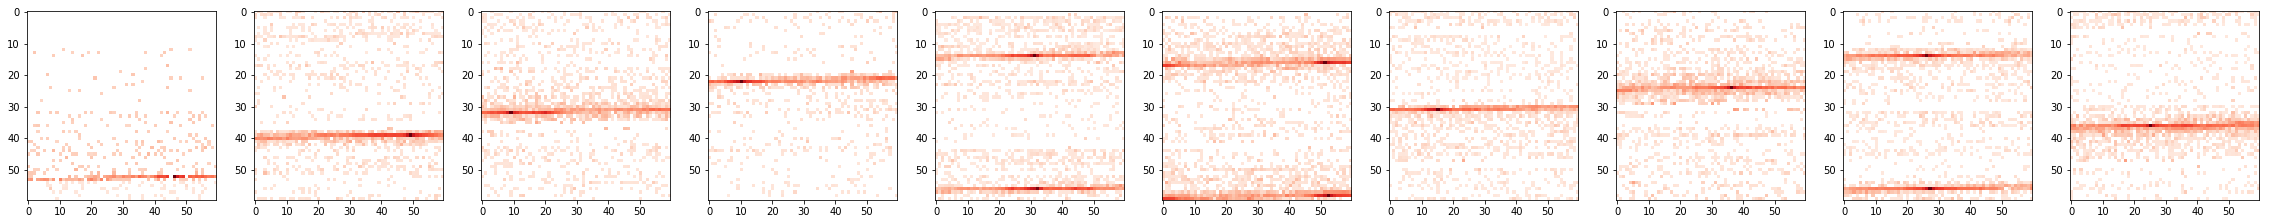

In [32]:
plot_sub_matrices(test, newcmp)

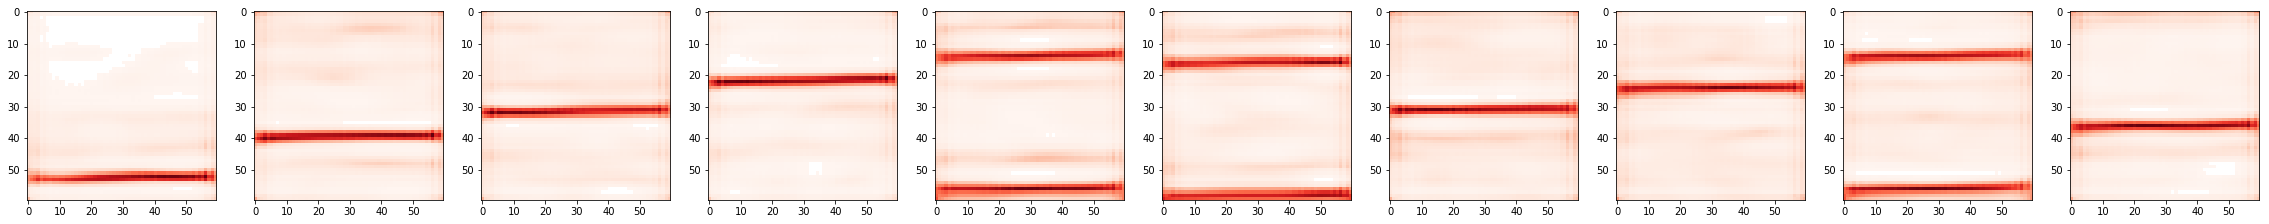

In [33]:
plot_sub_matrices(pred, newcmp)